# Comparing dashboard similarity

Comparing several different similarity metrics to see what yields the most reasonable dashboards

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
import pandas as pd
from tqdm.notebook import tqdm

from interpml import info_architecture as ia
from interpml import plotting, config

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Generating dashboards

In [2]:
# Parameters
components = np.arange(3) + 1
height, width = 10, 12
N = 20

In [3]:
# Defined by lists of (row1, col1, height, width) tuples

# 2-component dashboards
split = 8
spec1 = [
    (0, 0, height, split),
    (0, split, height, width - split)
]

split = 4
spec2 = [
    (0, 0, height, split),
    (0, split, height, width - split)
]

split = 4
spec3 = [
    (0, 0, split, width),
    (split, 0, height - split, width)
]

split = 6
spec4 = [
    (0, 0, split, width),
    (split, 0, height - split, width)
]

# 3-component dashboards
split = 6, 4
spec5 = [
    (0, 0, height, split[0]),
    (0, split[0], split[1], width - split[0]),
    (split[1], split[0], height - split[1], width - split[0])
]

split = 5, 6
spec6 = [
    (0, 0, height, split[0]),
    (0, split[0], split[1], width - split[0]),
    (split[1], split[0], height - split[1], width - split[0])
]

split = 5, 4
spec7 = [
    (0, 0, split[0], split[1]),
    (split[0], 0, height - split[0], split[1]),
    (0, split[1], height, width - split[1])
]

split = 4, 6
spec8 = [
    (0, 0, split[0], split[1]),
    (split[0], 0, height - split[0], split[1]),
    (0, split[1], height, width - split[1])
]

split = 4, 6
spec9 = [
    (0, 0, split[0], split[1]),
    (0, split[1], split[0], width - split[1]),
    (split[0], 0, height - split[0], width)
]

split = 6, 4
spec10 = [
    (0, 0, split[0], split[1]),
    (0, split[1], split[0], width - split[1]),
    (split[0], 0, height - split[0], width)
]

split = 4, 6
spec11 = [
    (0, 0, split[0], width),
    (split[0], 0, height - split[0], split[1]),
    (split[0], split[1], height - split[0], width - split[1])
]

split = 6, 4
spec12 = [
    (0, 0, split[0], width),
    (split[0], 0, height - split[0], split[1]),
    (split[0], split[1], height - split[0], width - split[1])
]

specs = [
    spec1, spec2, spec3, spec4, spec5, spec6,
    spec7, spec8, spec9, spec10, spec11, spec12
]

In [4]:
treemaps = []
info_archs = []
for i, arch in enumerate(specs):
    for j in range(3):
        arr = ia.spec2arr(arch, n_components=4, height=height, width=width)
        treemaps.append(arr)
        try:
            info_archs.append(ia.InfoArchTree.from_array(i * 20 + j, arr))
        except:
            pass

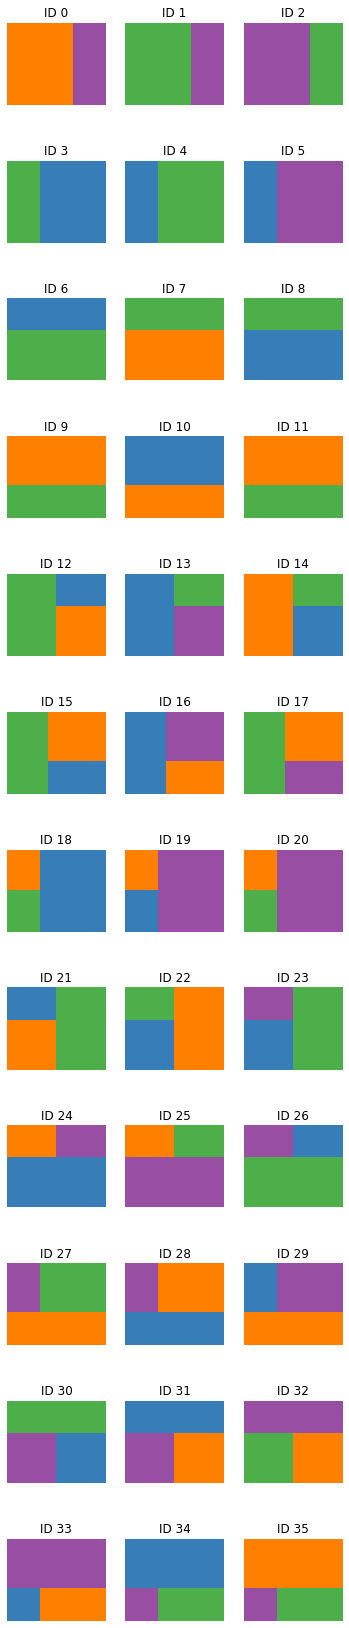

In [5]:
fig, axs = plt.subplots(len(specs), 3, figsize=(3 * 2, len(specs) * 2.5))
for i, (treemap, ax) in enumerate(zip(treemaps, axs.flat)):
    plotting.plot_treemap(treemap, ax=ax, vmin=0, vmax=9, cmap='Set1')
    ax.set_title(f'ID {i}')
    ax.axis('off')

## Producing file for annotation

In [6]:
n_anchors = 15
n_queries = 4
anchors = np.random.choice(len(treemaps), size=n_anchors, replace=False)
treemaps_idx = np.arange(len(treemaps))
queries = []
for anchor in anchors:
    bool_mask = np.ones(len(treemaps)).astype(bool)
    bool_mask[anchor] = False
    treemaps_no_anchor = treemaps_idx[bool_mask]
    queries_i = np.random.choice(treemaps_no_anchor, size=n_queries)
    queries.append(queries_i)

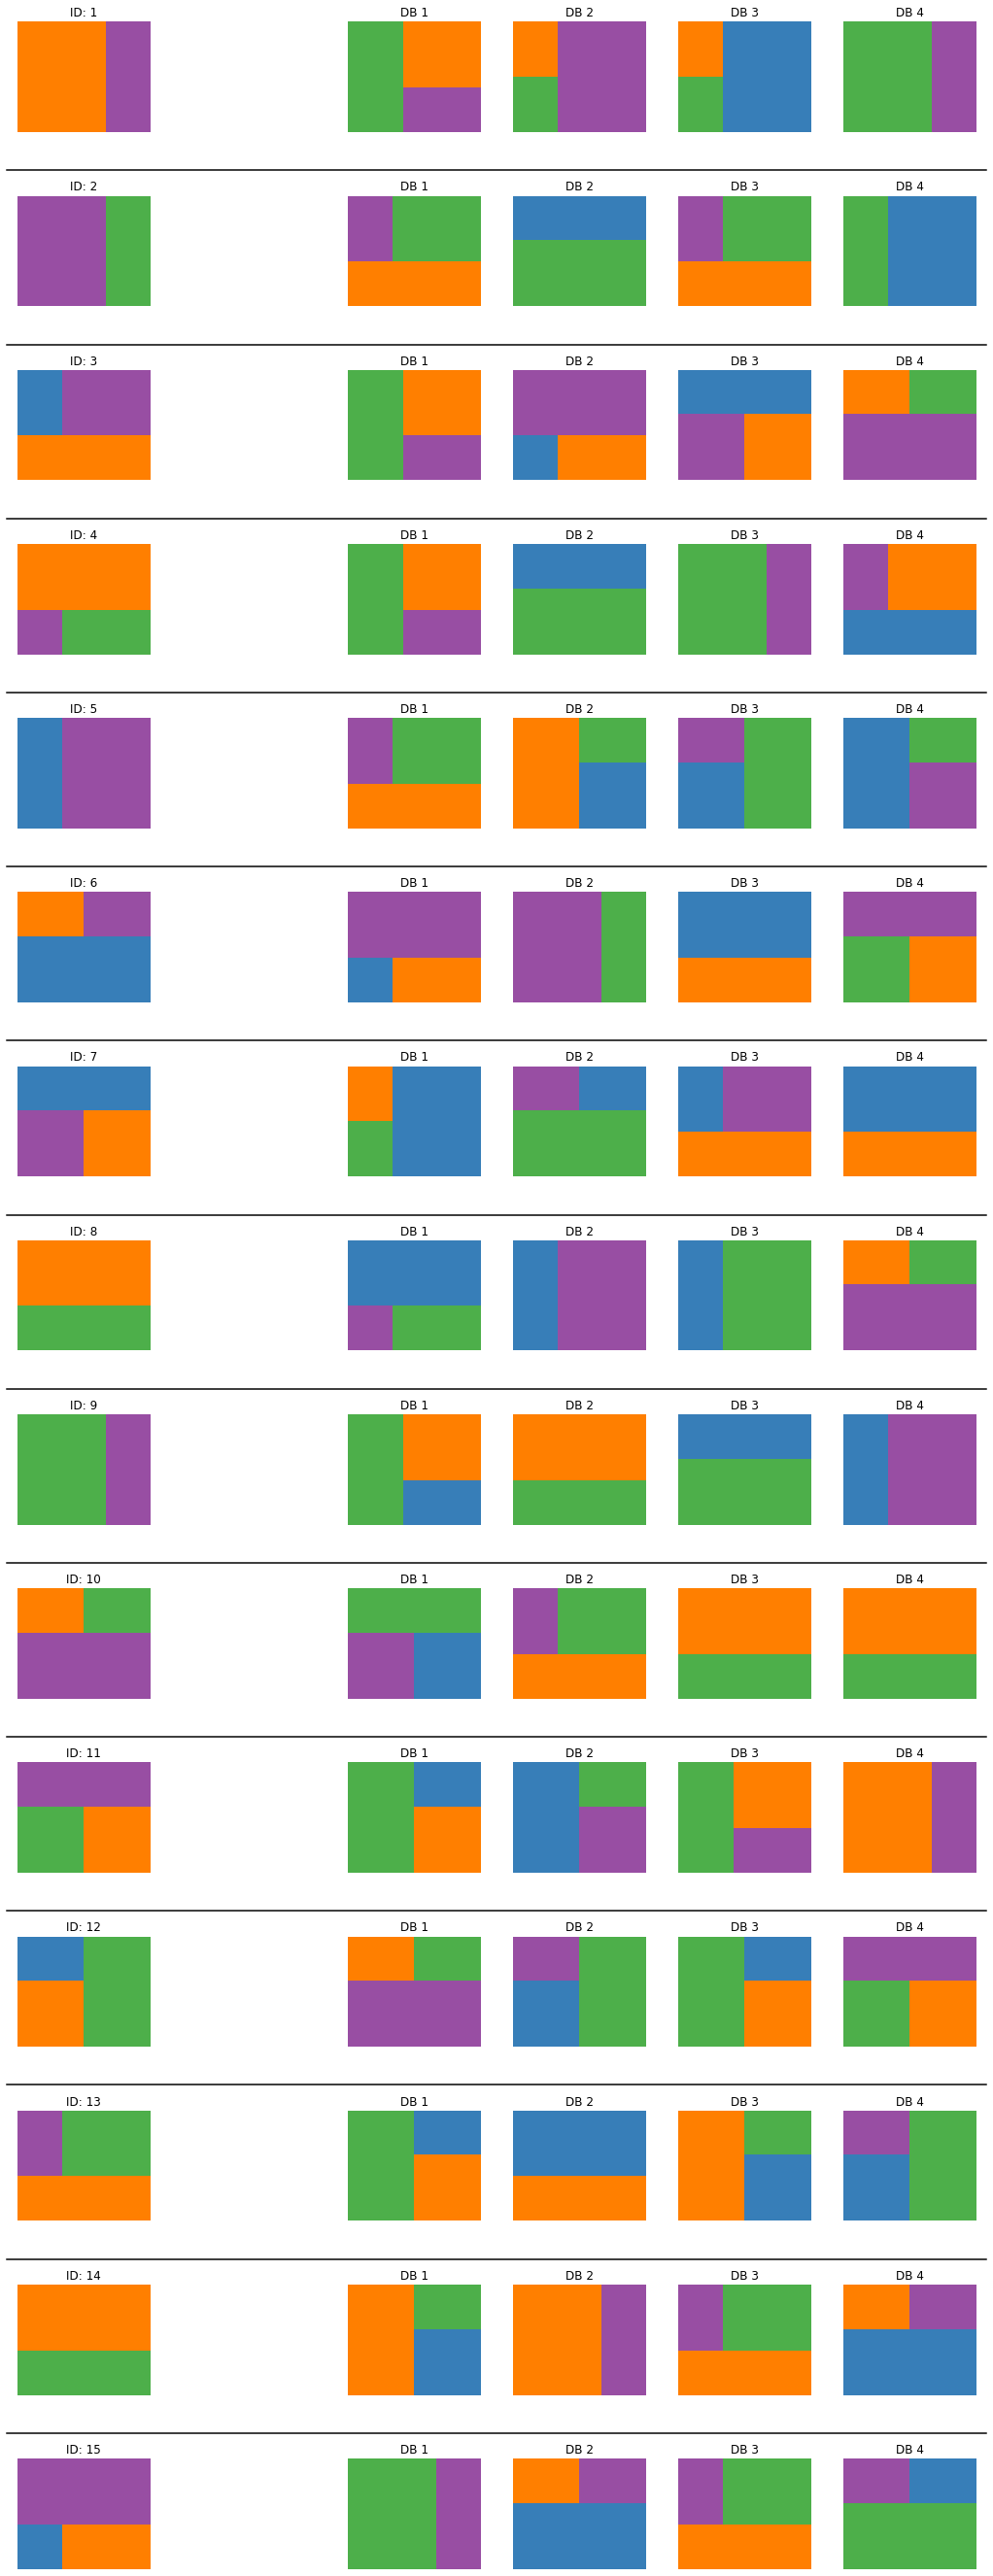

In [7]:
fig, axs = plt.subplots(n_anchors, n_queries + 2, figsize=((n_queries + 3) * 2., n_anchors * 2.5))
for i, anchor_idx in enumerate(anchors):
    plotting.plot_treemap(treemaps[anchor_idx], ax=axs[i, 0], vmin=0, vmax=9, cmap='Set1')
    axs[i, 0].axis('off')
    axs[i, 0].set_title(f"ID: {i+1}")
    for j, query_idx in enumerate(queries[i]):
        plotting.plot_treemap(treemaps[query_idx], ax=axs[i, j+2], vmin=0, vmax=9, cmap='Set1')
        axs[i, j+2].axis('off')
        axs[i, j+2].set_title(f"DB {j+1}")
        
fig.tight_layout()

r = fig.canvas.get_renderer()
get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
bboxes = np.array(list(map(get_bbox, axs.flat)), mtrans.Bbox).reshape(axs.shape)

ymax = np.array(list(map(lambda b: b.y1, bboxes.flat))).reshape(axs.shape).max(axis=1)
ymin = np.array(list(map(lambda b: b.y0, bboxes.flat))).reshape(axs.shape).min(axis=1)
ys = np.c_[ymax[1:], ymin[:-1]].mean(axis=1)

for y in ys:
    line = plt.Line2D([0, 1], [y, y], transform=fig.transFigure, color='k')
    fig.add_artist(line)
    
for ax in axs[:, 1]:
    ax.set_visible(False)

# plt.savefig(config.figs / 'db-similarity-task.png')
plt.show()

In [15]:
np.moveaxis(np.dstack(treemaps), 2, 0).shape

(36, 10, 12)

In [24]:
anchors = np.array(anchors).reshape(-1, 1)
queries = np.array(queries).reshape(-1, 4)
data = np.hstack((anchors, queries))
# np.savetxt(str(config.data / 'db-similarity-task.csv'), data, fmt='%.0f', delimiter=',')
data2 = np.dstack(treemaps).reshape(-1, len(treemaps))
# np.savetxt(str(config.data / 'db-similarity-treemaps.csv'), data2, fmt='%.0f', delimiter=',')
# np.save(str(config.data / 'db-similarity-treemaps.npy'), np.dstack(treemaps))

## Setting up similarity comparison

In [3]:
# Loading completed data
dfs = []
for i in [1, 2]:
    df_sims_i = pd.read_excel(config.data / 'db-similarity.xlsx', sheet_name=i)
    df_sims_i = df_sims_i.filter(regex="(Row ID)|(DB.*)", axis=1)
    df_sims_i = df_sims_i.rename(columns={
        'Row ID': 'anchor_id',
        'DB 1': 'db1',
        'DB 2': 'db2',
        'DB 3': 'db3',
        'DB 4': 'db4'
    })
    df_sims_i['annotator'] = i
    dfs.append(df_sims_i)

all_scores = np.dstack([df.filter(regex='db\d*', axis=1).values for df in dfs])
true_scores = np.mean(all_scores, axis=2)
db_ids = dfs[0]['anchor_id'].values

In [4]:
true_scores

array([[2. , 2. , 4. , 2. ],
       [2. , 2.5, 1.5, 3.5],
       [1.5, 2. , 1.5, 3.5],
       [1. , 3. , 3. , 2. ],
       [3.5, 2.5, 1.5, 1.5],
       [1.5, 4. , 3. , 1.5],
       [3. , 4. , 2. , 1. ],
       [3.5, 3.5, 1. , 1.5],
       [2. , 3. , 3.5, 1. ],
       [2. , 1. , 3. , 3.5],
       [2. , 4. , 1. , 2.5],
       [3. , 3. , 1. , 3. ],
       [2.5, 4. , 1.5, 1.5],
       [1. , 3. , 2. , 4. ],
       [3. , 2. , 2.5, 2. ]])

In [5]:
db_ids

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [6]:
all_ids = np.loadtxt(str(config.data / 'db-similarity-task.csv'), delimiter=',')
all_ids = all_ids.astype(int)
treemaps = np.load(str(config.data / 'db-similarity-treemaps.npy'))
treemaps = np.moveaxis(treemaps, 2, 0)

In [7]:
height, width = 10, 12
infoarchs = [ia.InfoArchTree.from_array(i, arr, height=height, width=width) for i, arr in enumerate(treemaps)]

## Testing different similarity functions

In [8]:
def score_sim_fn(f, infoarchs, ids, true_scores, args=None):
    '''Score the distance function `f`
    
    Arguments:
        f {callable} -- Distance function (larger means more distant)
            Must take two InfoArchTree's as arguments and return a scalar.
        infoarchs {iterable} -- iterable of information architectures.
        ids {np.ndarray} -- Array of ids to match infoarchs with true_scores.
        true_scores {np.ndarray} -- Array of mean rankings (matches id array).
    
    Keyword arguments:
        args {tuple | NoneType} -- Additional arguments to pass to `f`.
    '''
    rankings = []
    for i in range(ids.shape[0]):
        row = ids[i]
        anchor_id = row[0]
        anchor = infoarchs[anchor_id]
        
        row_scores = []
        for j, db_id in enumerate(row[1:]):
            comp = infoarchs[db_id]
            score = f(anchor, comp)
            row_scores.append(score)
        row_ranks = np.argsort(row_scores)
        rankings.append(row_ranks)
    
    rankings = np.array(rankings)
    mse = np.mean((true_scores - rankings).ravel() ** 2)
    return mse, rankings

In [9]:
components = np.unique(treemaps)
n_components = len(components)
n_features = 4


def _compute_distance(ia1, ia2, f, n_components, weights=None):
    feats1 = ia1.get_feature_vector(components=n_components, weights=weights)
    feats2 = ia2.get_feature_vector(components=n_components, weights=weights)
    return f(feats1, feats2)

def cosine_similarity(x1, x2):
    return 1 - (np.dot(x1, x2) / (np.linalg.norm(x1) * np.linalg.norm(x2)))

def euclidean_norm(x1, x2):
    return np.linalg.norm(x1 - x2)

def make_func(dist_func, weights):
    def f(ia1, ia2):
        return _compute_distance(ia1, ia2, dist_func, n_components, weights=weights)
    return f


weight_grid = [0, .5, 1, 5]
dist_funcs = [(cosine_similarity, 'cosine'), (euclidean_norm, 'euclidean')]

In [10]:
results = []
ranks = []
queries = []

with tqdm(total=len(dist_funcs) * len(weight_grid) ** len(weight_grid)) as pbar:
    for f, name in dist_funcs:
        for w1 in weight_grid:
            for w2 in weight_grid:
                for w3 in weight_grid:
                    for w4 in weight_grid:
                        weights = np.array([w1, w2, w3, w4])
                        fn = make_func(f, weights)
                        mse, ranks_i = score_sim_fn(fn, infoarchs, all_ids, true_scores)
                        results.append(mse)
                        ranks.append(ranks_i)
                        queries.append((name, weights))
                        
                        pbar.update()

/Users/benjaminlevy/Desktop/Benjamin/School/19_20/Classes/spring/cs271/project/interp-ml/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


In [11]:
results = np.array(results)

In [14]:
min_idxs = np.argwhere(results == np.min(results)).flatten()
for idx in min_idxs:
    print(queries[idx], results[idx])

('cosine', array([0.5, 0. , 0.5, 0. ])) 2.0416666666666665
('cosine', array([1, 0, 1, 0])) 2.0416666666666665
('cosine', array([5, 0, 5, 0])) 2.0416666666666665
('cosine', array([5. , 0. , 5. , 0.5])) 2.0416666666666665
('cosine', array([5, 0, 5, 1])) 2.0416666666666665
('cosine', array([5. , 0.5, 5. , 0. ])) 2.0416666666666665
('cosine', array([5. , 0.5, 5. , 0.5])) 2.0416666666666665
('cosine', array([5. , 0.5, 5. , 1. ])) 2.0416666666666665
('cosine', array([5, 1, 5, 0])) 2.0416666666666665
('cosine', array([5. , 1. , 5. , 0.5])) 2.0416666666666665
('cosine', array([5, 1, 5, 1])) 2.0416666666666665
('euclidean', array([5, 1, 5, 0])) 2.0416666666666665
('euclidean', array([5. , 1. , 5. , 0.5])) 2.0416666666666665
('euclidean', array([5, 1, 5, 1])) 2.0416666666666665


In [124]:
infoarchs[0].get_features()

,value,size,orientation,depth,priority
0,4.0,0.666667,1,0.333333,0.5
1,3.0,0.333333,1,1.000000,1.0


### Remarks

- Size and depth are _much_ more informative than orientation and priority. We can drop those
- In general, cosine similarity has more high-performing features. This might mean it is less sensitive to differences in weights. As well, the best Euclidean norm similarity functions have max weight on size and depth, and small but non-zero weight on orientation. Also no or very small weight on priority.